In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np
import numpy.polynomial.polynomial as P
import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
dst = '../clean/'
Anchors1 = []
for filename in sorted(glob.glob(dst + '*/diagnostic/anchors1.csv')):
    Anchors1.append(np.sort(np.loadtxt(filename, dtype='float', delimiter=',')))
anchors1 = np.vstack(Anchors1)

Loc_Maxa = []
for filename in sorted(glob.glob(dst + '*/diagnostic/local_maxima.csv')):
    Loc_Maxa.append(np.sort(np.loadtxt(filename, dtype='int', delimiter=',')))
loc_maxa = np.vstack(Loc_Maxa)

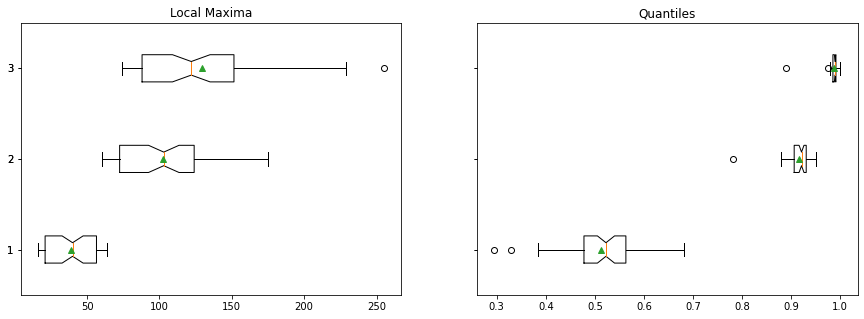

In [3]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
ax = np.atleast_1d(ax).ravel()

i = 0
foo = ax[i].boxplot(loc_maxa, notch=True, vert=False, showmeans=True);
ax[i].set_title('Local Maxima');
i = 1
foo = ax[i].boxplot(anchors1, notch=True, vert=False, showmeans=True);
ax[i].set_title('Quantiles');

In [4]:
print(np.median(loc_maxa, axis=0))
print(np.quantile(loc_maxa, 0.75, axis=0))
print(np.median(anchors1, axis=0))

[ 40. 103. 122.]
[ 56.5 124.  151.5]
[0.52268214 0.92105655 0.98927759]


In [5]:
filesrc = '../clean/2014SBa_R1_T25/diagnostic/'
#anchors0 = np.loadtxt(filesrc+'anchors0.csv', dtype='float', delimiter=',')
#anchors1 = np.loadtxt(filesrc+'anchors1.csv', dtype='float', delimiter=',')
loc_maxa = np.loadtxt(filesrc+'local_maxima.csv', dtype='int', delimiter=',')

In [6]:
y = np.median(loc_maxa, axis=0)
anchors = np.median(anchors1, axis = 0)
print(y)
print(anchors)

[ 40.5 172.  223.5]
[0.52268214 0.92105655 0.98927759]


## Load scans

In [9]:
walnut_batch = sorted(glob.glob('../raw/*/'))
bidx = 0
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))
bname = walnut_batch[bidx].split('/')[-2]
wdst = dst + bname + '/'
print(bname)

2014SBa_R1_T25


In [12]:
bname

'2014SBa_R1_T25'

In [21]:
widx = 7
print(walnut_files[widx])
img = tf.imread(walnut_files[widx])//256
img = img.astype(np.uint8)

#img = ndimage.gaussian_filter(img, sigma=3, mode='constant')

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

hist0,bins = np.histogram(img, bins=2**(img.dtype.itemsize*8),range=(0,2**(img.dtype.itemsize*8)))
fhist = ndimage.median_filter(hist0, size=5, mode='constant', cval=0)
cumul = np.cumsum(fhist)

../raw/2014SBa_R1_T25/008.tif
008


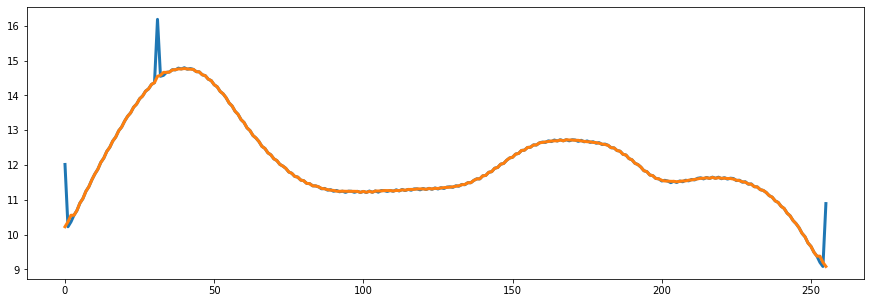

In [22]:
lw=3
fig = plt.figure(figsize=(15,5))
plt.plot(np.log(hist0 +1), lw=lw);
plt.plot(np.log(fhist+1), lw=lw);

In [23]:
tot = cumul[-1]
x = np.zeros(len(anchors))
for i,a in enumerate(anchors):
    for j,s in enumerate(cumul):
        if s>a*tot:
            print('[ {} , {:03d} ]:\t {} > {:.3f}*{}\t = {:.0f}'.format(i,j,s,a,tot,a*tot))
            #print('[',i,',',j,']: ',s,'>',a,'*',tot,'=',a*tot)
            break
    if j > 0:
        x[i] = j-1+(a*tot-cumul[j-1])/(cumul[j]-cumul[j-1])
    else:
        x[i] = 0
print('\n',x)

npz = P.Polynomial.fit(x,y,1)
print(npz.convert().coef)

[ 0 , 046 ]:	 54072953 > 0.523*99551995	 = 52034050
[ 1 , 181 ]:	 91864306 > 0.921*99551995	 = 91693017
[ 2 , 230 ]:	 98502242 > 0.989*99551995	 = 98484557

 [ 45.06128187 180.41516609 229.81146493]
[-4.38048032  0.98649981]


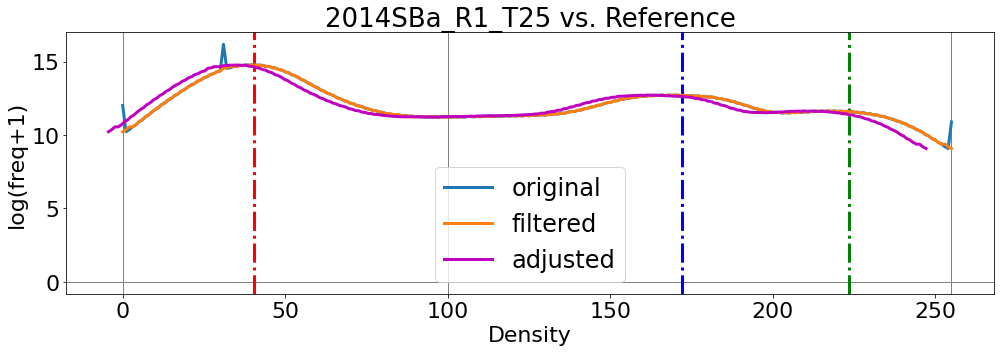

In [24]:
fig, ax = plt.subplots(figsize=(14,5))
lw = 3

ax.axhline(0, c='gray', lw=1)
ax.axvline(y[0], ls='-.', lw=lw, c='r')
ax.axvline(y[1], ls='-.', lw=lw, c='b')
ax.axvline(y[2], ls='-.', lw=lw, c='g')
ax.axvline(0, c='gray', lw=1)
ax.axvline(255, c='gray', lw=1)
ax.axvline(100, c='gray', lw=1)

ax.plot(bins[:-1], np.log(hist0+1), lw=lw, label = 'original')
ax.plot(bins[:-1], np.log(fhist+1), lw=lw, label = 'filtered')
ax.plot(npz(bins[:-1]), np.log(fhist+1), lw=lw, label = 'adjusted', c='m')

ax.set_xlabel("Density", fontsize=22)
ax.set_ylabel("log(freq+1)", fontsize=22)
ax.set_title(bname + ' vs. Reference', fontsize=26)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)
plt.tight_layout()

In [25]:
aimg = img.copy()
aimg = wnut.normalize_density(aimg, npz)

thr = 100
struc = ndimage.generate_binary_structure(img.ndim, 2)
cimg = aimg.copy()
cimg[cimg < thr] = 0

oimg = wnut.fill_component(cimg)
oimg = wnut.get_largest_element(oimg)

Closed X
Closed Y
Closed Z
1754 components	 1 preserved
[33553662      312       60       56       32       32       25       22
       19       19       18       17       15       14       14       14
       14       13       13       13]


In [26]:
struc = ndimage.generate_binary_structure(img.ndim, 1)

eimg = ndimage.binary_erosion(oimg, struc, 3, border_value=1)
eimg = ndimage.binary_dilation(eimg, struc, 3, border_value=0)#structure = struc)


cimg = (eimg > 0)*aimg

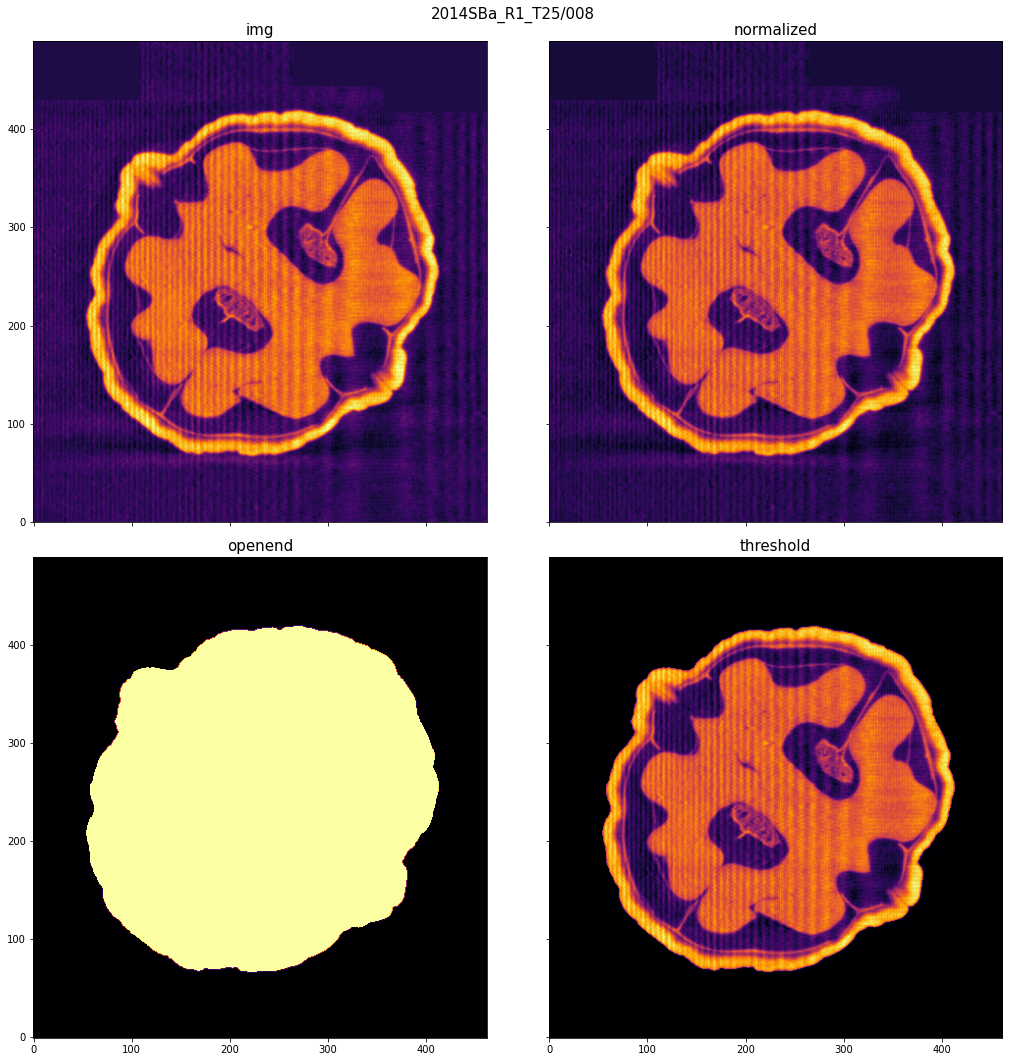

In [27]:
fs = 15
k = 150
ss = np.s_[k,:,:]

fig, ax = plt.subplots(2,2,figsize=(15,15), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('img', fontsize=fs)
i = 1
ax[i].imshow(aimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('normalized', fontsize=fs)
i = 2
ax[i].imshow(oimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
ax[i].set_title('openend', fontsize=fs)
i = 3
ax[i].imshow(cimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
ax[i].set_title('threshold', fontsize=fs)

fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

In [28]:
walnut, cero = wnut.clean_zeroes(cimg)
print(cimg.shape)
print(walnut.shape)

40 % reduction from input
(478, 490, 462)
(466, 377, 370)


In [29]:
bwalnut = walnut.copy()
bwalnut[bwalnut > 0] = 1

fwalnut = walnut.copy()
fwalnut[fwalnut > 0] = 1
fwalnut = ndimage.binary_fill_holes(fwalnut)
#fwalnut = wnut.fill_component(fwalnut, x=False, y=True, z=False)
fwalnut = wnut.fill_component(fwalnut)

Closed X
Closed Y
Closed Z


In [30]:
diff = fwalnut - bwalnut
print(np.sum(diff))
walnut[diff > 0] = 1

5314


In [31]:
filename = wdst + fname + '.tif'
print(filename)
tf.imwrite(filename, walnut, photometric='minisblack', compress=3)

../clean/2014SBa_R1_T25/008.tif


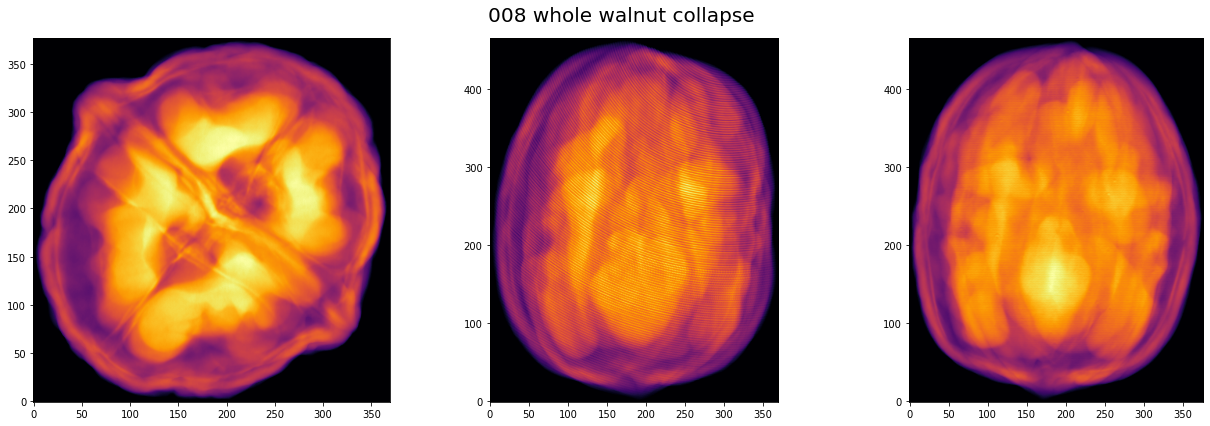

In [32]:
snaps = wnut.collapse_dimensions(walnut)
wnut.plot_collapse_dimensions(snaps, fname, 'whole walnut', dst=wdst)

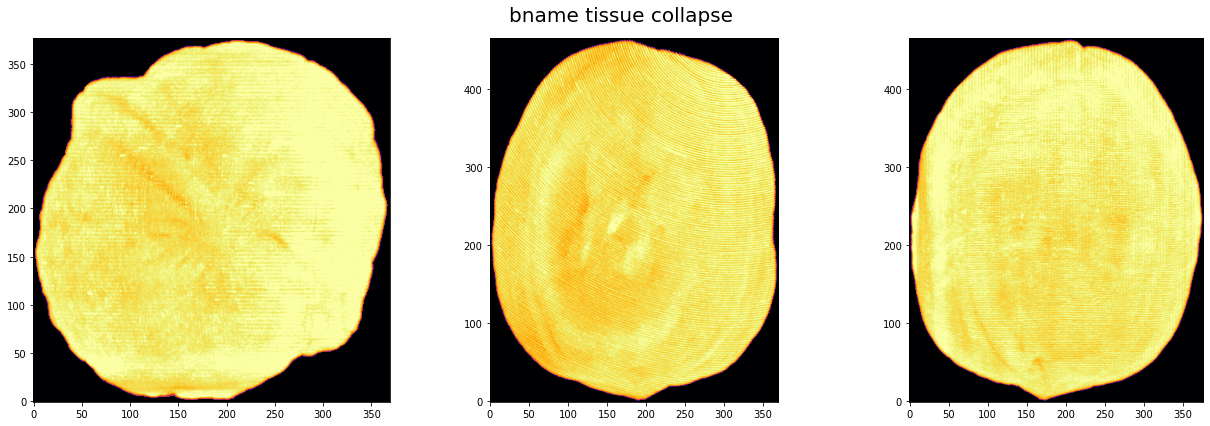

In [33]:
snaps = wnut.collapse_dimensions_max(walnut)
wnut.plot_collapse_dimensions(snaps)